# Generate Mask from CUB Keypoints

In [2]:
import os
import numpy as np
from glob import glob
import matplotlib
from matplotlib import pyplot as plt

from torchvision.datasets import ImageFolder
from matplotlib.patches import Rectangle
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
import pickle
import seaborn as sns
sns.set()

In [3]:
display_transform = transforms.Compose(
   [transforms.Resize(240),
    transforms.CenterCrop((240, 240))])

In [4]:
with open('/home/mohammad/dataset/CUB_200_2011/train_test_split.txt', 'r') as f:
  tts = f.readlines()
  
with open('/home/mohammad/dataset/CUB_200_2011/bounding_boxes.txt', 'r') as f:
  bbox = f.readlines()

with open('/home/mohammad/dataset/CUB_200_2011/parts/part_locs.txt', 'r') as f:
  ploc = f.readlines()

with open('/home/mohammad/dataset/CUB_200_2011/images.txt', 'r') as f:
  images = f.readlines()

In [5]:
cub_all = ImageFolder('/home/mohammad/dataset/CUB_200_2011/images/')

In [6]:
points = [float(x) for x in bbox[0].strip().split(' ')[1:]]

In [7]:
def get_visible_key_points(bid):
  return [x.strip().split(' ') for x in ploc if int(x.strip().split(' ')[0]) == bid and int(x.strip().split(' ')[-1])==1]

### Selected Keypoints

In [8]:
# 1 back
# 2 beak
# 3 belly
# 4 breast
# 5 crown
# 6 forehead
# 7 left eye
# 8 left leg
# 9 left wing
# 10 nape
# 11 right eye
# 12 right leg
# 13 right wing
# 14 tail
# 15 throat

def get_keypoints_only5(bid):
  kpoints = get_visible_key_points(bid)
  top_5s = [x for x in kpoints if int(x[1]) in [2, 3, 14, 13, 12]]
  
  xs = [float(x[2]) for x in top_5s]
  ys = [float(y[3]) for y in top_5s]
  return xs, ys

def get_keypoints(bid):
  kpoints = get_visible_key_points(bid)
  xs = [float(x[2]) for x in kpoints]
  ys = [float(y[3]) for y in kpoints]
  return xs, ys

In [9]:
get_visible_key_points(1)

[['1', '2', '312.0', '182.0', '1'],
 ['1', '5', '186.0', '45.0', '1'],
 ['1', '6', '247.0', '79.0', '1'],
 ['1', '10', '100.0', '221.0', '1'],
 ['1', '11', '183.0', '101.0', '1'],
 ['1', '15', '215.0', '194.0', '1']]

In [10]:
get_keypoints(1)

([312.0, 186.0, 247.0, 100.0, 183.0, 215.0],
 [182.0, 45.0, 79.0, 221.0, 101.0, 194.0])

In [11]:
get_keypoints_only5(1)

([312.0], [182.0])

### Generate Mask - All visible parts

In [12]:
def generate_mask(bid):
  Xs, Ys = get_keypoints(bid)
  img = Image.open('/home/mohammad/dataset/CUB_200_2011/images/' + images[bbid-1].strip().split(' ')[1])
  
  size = 240
  w, h = img.size
  short, long = (w, h) if w <= h else (h, w)
  new_short, new_long = size, int(size * long / short)
  new_w, new_h = (new_short, new_long) if w <= h else (new_long, new_short)
  
  Xs = new_w*np.asarray(Xs)/img.width
  Ys = new_h*np.asarray(Ys)/img.height
  
  # img = img.resize((new_w, new_h), Image.BILINEAR)
  
  left = (new_w - 240)/2
  top = (new_h - 240)/2
  
  Xs -= left
  Ys -= top
  
  MXs = Xs//34
  MYs = Ys//34
  MASK = np.zeros((7, 7))
  for i, j in zip (MXs, MYs):
    if i<7 and j < 7:
      MASK[int(i), int(j)] = 1
    
  return Xs, Ys, MASK.T

### Preview

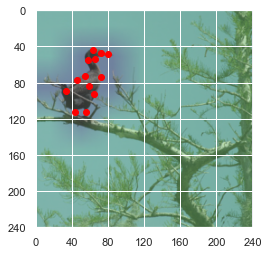

In [13]:
fig, ax = plt.subplots(1)
bbid = 1324
XX, YY , M = generate_mask(bbid)
img = Image.open('/home/mohammad/dataset/CUB_200_2011/images/' +images[bbid-1].strip().split(' ')[1])

ax.imshow(display_transform(img))
ax.scatter(XX, YY, c='red')
ax.imshow(display_transform(Image.fromarray(np.uint8(matplotlib.cm.Accent(M)*255))), alpha=0.5)

ax.set_xticks(np.linspace(0, 240, 7))
ax.set_yticks(np.linspace(0, 240, 7))
plt.show()

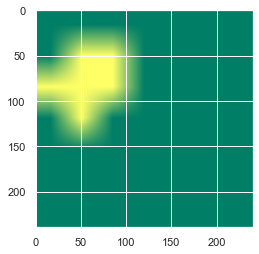

In [14]:
plt.imshow(display_transform(Image.fromarray(np.uint8(matplotlib.cm.summer(M)*255))), alpha=1)

In [ ]:
# Can be speed up with Joblib

mask_dict = {}
for bbid in tqdm(range(1, len(images)+1)):
  x, y, M =  generate_mask(bbid)
  mask_dict[images[bbid-1].strip().split(' ')[1]] = M

  2%|██▉                                                                                                                                                                           | 203/11788 [00:25<30:28,  6.33it/s]

In [ ]:
with open('CUB-Mask-All-Visible-Parts.pkl', 'wb') as f:
  pickle.dump(mask_dict, f)

### Generate Mask - Selected Parts

In [ ]:
def generate_mask_selectedkpoints(bid):
  Xs, Ys = get_keypoints_only5(bid)
  img = Image.open('/home/mohammad/dataset/CUB_200_2011/images/' + images[bbid-1].strip().split(' ')[1])
  
  size = 240
  w, h = img.size
  short, long = (w, h) if w <= h else (h, w)
  new_short, new_long = size, int(size * long / short)
  new_w, new_h = (new_short, new_long) if w <= h else (new_long, new_short)
  
  Xs = new_w*np.asarray(Xs)/img.width
  Ys = new_h*np.asarray(Ys)/img.height
  
  left = (new_w - 240)/2
  top = (new_h - 240)/2
  
  Xs -= left
  Ys -= top
  
  MXs = Xs//34
  MYs = Ys//34
  MASK = np.zeros((7, 7))
  for i, j in zip (MXs, MYs):
    if i<7 and j < 7:
      MASK[int(i), int(j)] = 1
    
  return Xs, Ys, MASK.T

In [ ]:
mask_dict = {}
for bbid in tqdm(range(1, len(images)+1)):
  x, y, M =  generate_mask_selectedkpoints(bbid)
  mask_dict[images[bbid-1].strip().split(' ')[1]] = M

In [ ]:
with open('CUB-Mask-Top5.pkl', 'wb') as f:
  pickle.dump(mask_dict, f)

In [ ]:
with open('/home/mohammad/dataset/CUB_200_2011/parts/part_locs.txt', 'r') as f:
  ploc = f.readlines()
  
ploc = [x.split() for x in ploc ]

In [ ]:
np.histogram([int(x[1]) for x in ploc if x[-1]!='0'])

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

from collections import Counter

In [ ]:
part_counter = Counter([int(x[1]) for x in ploc if x[-1]!='0'])

In [ ]:
name_translator = {
  1: 'back',
  2: 'beak',
  3: 'belly',
  4: 'breast',
  5: 'crown',
  6: 'forehead',
  7: 'left eye',
  8: 'left leg',
  9: 'left wing',
  10: 'nape',
  11: 'right eye',
  12: 'right leg',
  13: 'right wing',
  14: 'tail',
  15: 'throat'}

In [ ]:
part_counter

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 7))
labels, values = zip(*list(sorted(list(part_counter.items()), key=lambda x:x[1])))

labels = [name_translator[x] for x in labels]

indexes = np.arange(len(labels))
width = 1

ax.bar(indexes, values, width)
ax.set_xticks(indexes)
ax.set_xticklabels(labels, rotation=90, fontsize=14)
plt.title('Histogram of VISIBLE Parts for CUB dataset', fontsize=16)
plt.show()

In [ ]:
labels[::-1]

In [ ]:
# all keypoints
# 5 keypoints

# run for 10 keypoints and compare 5, if better, then 
# or 15